In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# --- 1. Physical Parameters ---
L = 1.0           # Length of the 1D battery component (normalized to 1.0)
T_total = 0.5     # Total simulation time
alpha = 0.01      # Thermal diffusivity (typical for certain ceramic solid-state electrolytes)

# --- 2. Grid Parameters (Finite Difference Setup) ---
Nx = 100          # Number of spatial points
Nt = 2500         # Number of time steps

dx = L / (Nx - 1)
dt = T_total / Nt

# --- 3. Stability Check (Courant-Friedrichs-Lewy condition for diffusion) ---
# For the explicit FTCS (Forward Time Centered Space) method to be stable,
# this ratio must be <= 0.5
cfl = alpha * dt / (dx**2)
print(f"Stability Criterion (must be <= 0.5): {cfl:.4f}")
if cfl > 0.5:
    raise ValueError("Simulation is unstable! Increase Nt or decrease Nx.")

# Create the spatial and temporal grids
x = np.linspace(0, L, Nx)
t = np.linspace(0, T_total, Nt)

Stability Criterion (must be <= 0.5): 0.0196


In [ ]:
# --- 1. Initialize Temperature Matrix ---
# u[n, i] will be the temperature at time step n and spatial point i
u = np.zeros((Nt, Nx))

# --- 2. Initial Condition (IC) ---
# The battery starts at a normalized room temperature of 0.0
u[0, :] = 0.0

# --- 3. Boundary Conditions (BCs) ---
# Left end (x=0) heats up to 1.0, Right end (x=L) is cooled to 0.0
u[:, 0] = 1.0
u[:, -1] = 0.0

# --- 4. FTCS Numerical Integration ---
# This loop calculates the temperature evolution step-by-step
for n in range(0, Nt - 1):
    for i in range(1, Nx - 1):
        # The core Finite Difference discretized equation
        u[n+1, i] = u[n, i] + alpha * dt / dx**2 * (u[n, i+1] - 2*u[n, i] + u[n, i-1])

print("Data generation complete. Physics simulated successfully.")

Data generation complete. Physics simulated successfully.


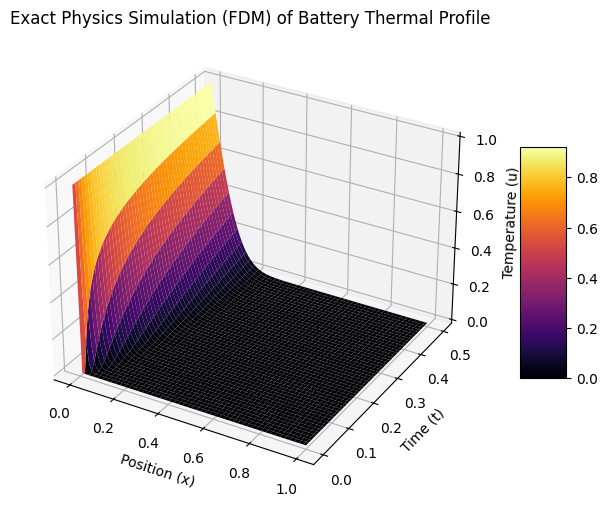

Dataset saved! Shape of inputs (x, t): torch.Size([250000, 2]), Shape of targets (u): torch.Size([250000, 1])


In [ ]:
# --- 1. Visualize the Heat Transfer ---
X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, u, cmap='inferno', edgecolor='none')

ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Temperature (u)')
ax.set_title('Exact Physics Simulation (FDM) of Battery Thermal Profile')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# --- 2. Prepare Data for PyTorch (PINN Training) ---
# Flatten the grids and temperature matrix into column vectors
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
Exact_u = u.flatten()[:, None]

# Combine X and T into our input feature matrix
X_star = np.hstack((X_flat, T_flat))
u_star = Exact_u

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X_star, dtype=torch.float32)
u_tensor = torch.tensor(u_star, dtype=torch.float32)

# Save the dataset locally in Colab
torch.save({'X': X_tensor, 'u': u_tensor}, 'battery_thermal_data.pt')
print(f"Dataset saved! Shape of inputs (x, t): {X_tensor.shape}, Shape of targets (u): {u_tensor.shape}")

In [ ]:
import torch.nn as nn

# --- 1. Define the PINN Architecture ---
class BatteryPINN(nn.Module):
    def __init__(self):
        super(BatteryPINN, self).__init__()

        # Input: [x, t] (2 features)
        # Hidden layers: 3 layers, 32 neurons each
        # Output: [u] (1 feature - Temperature)
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),  # Tanh is smooth and infinitely differentiable
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = BatteryPINN()
print("Model Architecture:")
print(model)

Model Architecture:
BatteryPINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
# --- 2. The Physics-Informed Loss Function ---
def physics_loss(model, x_collocation, t_collocation, alpha=0.01):
    # We must explicitly tell PyTorch to track gradients for these inputs
    x_collocation.requires_grad = True
    t_collocation.requires_grad = True

    # Combine x and t into a single input tensor of shape (N, 2)
    inputs = torch.cat([x_collocation, t_collocation], dim=1)

    # Forward pass: get the model's temperature prediction
    u_pred = model(inputs)

    # 1st Derivatives: du/dt and du/dx
    # We use torch.autograd.grad to compute exact derivatives
    u_t = torch.autograd.grad(
        u_pred, t_collocation,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u_pred, x_collocation,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]

    # 2nd Derivative: d^2u/dx^2 (Spatial diffusion)
    u_xx = torch.autograd.grad(
        u_x, x_collocation,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]

    # The physics residual (Heat Equation)
    pde_residual = u_t - alpha * u_xx

    # The loss is the Mean Squared Error of how far the residual is from 0
    loss_pde = torch.mean(pde_residual ** 2)

    return loss_pde

print("Physics loss function defined successfully.")

Physics loss function defined successfully.


In [ ]:
import torch.optim as optim

# --- 1. Random Seed for Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)

# --- 2. Sample Data Points (Boundary and Initial Conditions) ---
# We simulate a "data-scarce" environment by only taking 2,000 exact data points
N_u = 2000
idx_data = np.random.choice(X_tensor.shape[0], N_u, replace=False)
X_train_data = X_tensor[idx_data]
u_train_data = u_tensor[idx_data]

# --- 3. Sample Collocation Points (For Physics Loss) ---
# We pick 10,000 random points in the domain to enforce the heat equation
N_f = 10000
idx_colloc = np.random.choice(X_tensor.shape[0], N_f, replace=False)
X_train_colloc = X_tensor[idx_colloc]

# Separate x and t for the collocation points so we can compute derivatives
x_colloc = X_train_colloc[:, 0:1].clone().detach().requires_grad_(True)
t_colloc = X_train_colloc[:, 1:2].clone().detach().requires_grad_(True)

# --- 4. Define the Optimizer ---
# Adam is highly effective for initial PINN convergence
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Training Data points (N_u): {X_train_data.shape[0]}")
print(f"Collocation points (N_f): {x_colloc.shape[0]}")

Training Data points (N_u): 2000
Collocation points (N_f): 10000


In [ ]:
# --- 1. Training Parameters ---
epochs = 5000 # 5000 epochs is a good baseline to see convergence
lambda_physics = 1e-3 # Weighting factor for the physics loss

# Lists to track loss for visualization later
history_loss_data = []
history_loss_pde = []
history_loss_total = []

print("Starting PINN Training...")

# --- 2. The Training Loop ---
for epoch in range(epochs + 1):
    optimizer.zero_grad()

    # -- A. Data Loss (MSE on known points) --
    u_pred_data = model(X_train_data)
    loss_data = torch.mean((u_pred_data - u_train_data) ** 2)

    # -- B. Physics Loss (PDE residual on collocation points) --
    # Re-using the physics_loss function we built in Cell 5
    loss_pde = physics_loss(model, x_colloc, t_colloc, alpha=0.01)

    # -- C. Total Loss --
    # Combine the losses. lambda_physics helps balance the gradients.
    loss_total = loss_data + (lambda_physics * loss_pde)

    # -- D. Backpropagation --
    loss_total.backward()
    optimizer.step()

    # Store metrics
    history_loss_data.append(loss_data.item())
    history_loss_pde.append(loss_pde.item())
    history_loss_total.append(loss_total.item())

    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch:04d} | Total Loss: {loss_total.item():.6f} | Data Loss: {loss_data.item():.6f} | PDE Loss: {loss_pde.item():.6f}")

print("Training Complete!")

Starting PINN Training...
Epoch 0000 | Total Loss: 0.033962 | Data Loss: 0.033962 | PDE Loss: 0.000004
Epoch 0500 | Total Loss: 0.000754 | Data Loss: 0.000732 | PDE Loss: 0.022109
Epoch 1000 | Total Loss: 0.000338 | Data Loss: 0.000327 | PDE Loss: 0.010615
Epoch 1500 | Total Loss: 0.000170 | Data Loss: 0.000151 | PDE Loss: 0.019402
Epoch 2000 | Total Loss: 0.000125 | Data Loss: 0.000109 | PDE Loss: 0.016230
Epoch 2500 | Total Loss: 0.000090 | Data Loss: 0.000077 | PDE Loss: 0.013660
Epoch 3000 | Total Loss: 0.000069 | Data Loss: 0.000055 | PDE Loss: 0.013041
Epoch 3500 | Total Loss: 0.000057 | Data Loss: 0.000045 | PDE Loss: 0.012476
Epoch 4000 | Total Loss: 0.000046 | Data Loss: 0.000034 | PDE Loss: 0.011536
Epoch 4500 | Total Loss: 0.000038 | Data Loss: 0.000028 | PDE Loss: 0.010409
Epoch 5000 | Total Loss: 0.000032 | Data Loss: 0.000023 | PDE Loss: 0.009182
Training Complete!


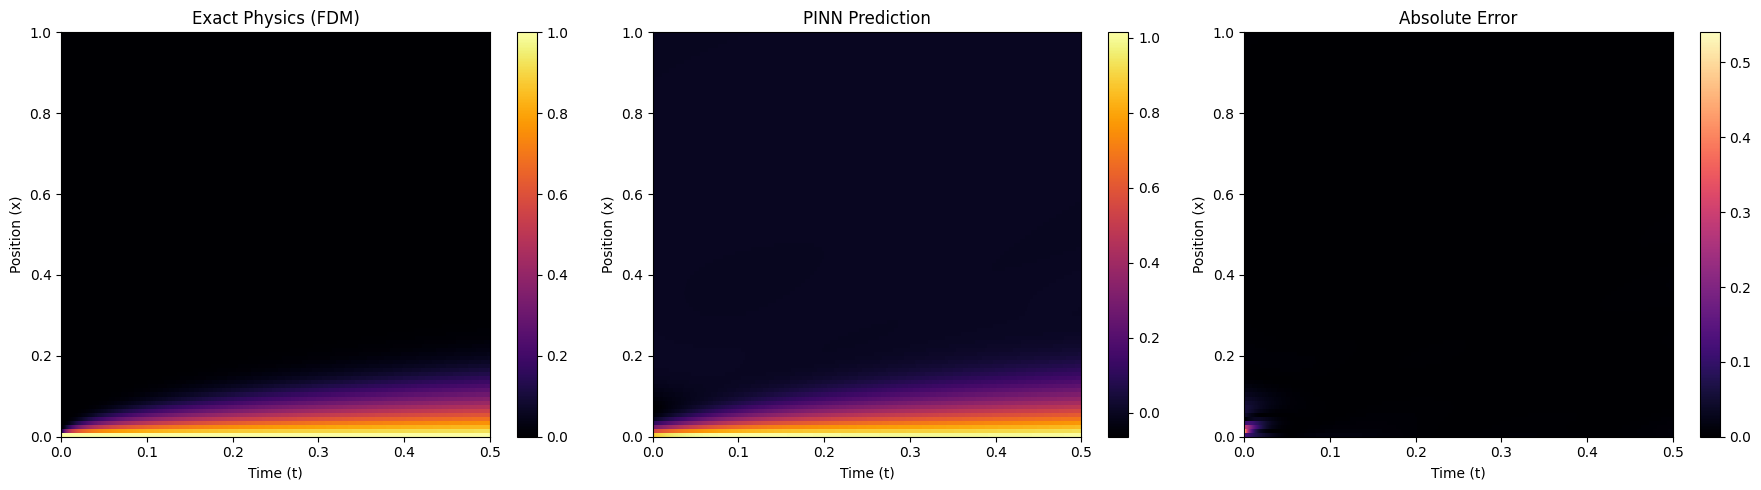

Relative L2 Error of the PINN: 3.5955%


In [ ]:
# --- 1. Evaluate the Trained PINN on the Full Domain ---
model.eval() # Set model to evaluation mode
with torch.no_grad(): # We don't need gradients for inference
    u_pred_tensor = model(X_tensor)

# Convert predictions back to numpy and reshape to the grid
u_pred = u_pred_tensor.numpy().reshape(Nt, Nx)
u_exact = u_tensor.numpy().reshape(Nt, Nx)

# Calculate Absolute Error
error = np.abs(u_exact - u_pred)

# --- 2. Plot the Results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Exact FDM Solution
im0 = axes[0].imshow(u_exact.T, interpolation='nearest', cmap='inferno',
                  extent=[0, T_total, 0, L], origin='lower', aspect='auto')
axes[0].set_title('Exact Physics (FDM)')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('Position (x)')
fig.colorbar(im0, ax=axes[0])

# Plot B: PINN Prediction
im1 = axes[1].imshow(u_pred.T, interpolation='nearest', cmap='inferno',
                  extent=[0, T_total, 0, L], origin='lower', aspect='auto')
axes[1].set_title('PINN Prediction')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Position (x)')
fig.colorbar(im1, ax=axes[1])

# Plot C: Absolute Error
im2 = axes[2].imshow(error.T, interpolation='nearest', cmap='magma',
                  extent=[0, T_total, 0, L], origin='lower', aspect='auto')
axes[2].set_title('Absolute Error')
axes[2].set_xlabel('Time (t)')
axes[2].set_ylabel('Position (x)')
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# --- 3. Final Metric ---
l2_error = np.linalg.norm(u_exact - u_pred, 2) / np.linalg.norm(u_exact, 2)
print(f"Relative L2 Error of the PINN: {l2_error:.4%}")

In [ ]:
# Save the trained model's state dictionary
torch.save(model.state_dict(), 'thermal_pinn_weights.pth')
print("Model weights saved successfully for deployment!")

Model weights saved successfully for deployment!


In [ ]:
# 1. Install the API web server libraries
!pip install fastapi uvicorn nest-asyncio

from fastapi import FastAPI
from pydantic import BaseModel
import torch
import nest_asyncio
import uvicorn
import threading
import json

# 2. Define the JSON data structure we expect from users
class BatteryData(BaseModel):
    x: float
    t: float

# 3. Initialize the API Web App
app = FastAPI(title="PINN Thermal Degradation API")

# 4. Create the API Endpoint
@app.post("/predict")
def get_prediction(data: BatteryData):
    # Convert incoming JSON data to PyTorch Tensor
    input_tensor = torch.tensor([[data.x, data.t]], dtype=torch.float32)

    # Get the AI's prediction
    with torch.no_grad():
        prediction = model(input_tensor)

    # Return JSON response
    return {"predicted_temperature": prediction.item()}

print("API is built and ready to run!")

API is built and ready to run!


In [ ]:
import requests
import time

# 1. Start the API server in the background
def run_api():
    nest_asyncio.apply()
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")

api_thread = threading.Thread(target=run_api, daemon=True)
api_thread.start()

# Give the server 2 seconds to boot up
time.sleep(2)

# --- THE PORTFOLIO TEST ---
# 2. This is the JSON payload a user/factory would send to your AI
test_payload = {
    "x": 0.2,  # Position in the battery
    "t": 0.4   # Time exposed to heat
}

print(f"Sending JSON request to API: {test_payload}")

# 3. Fire the web request at your live API
response = requests.post("http://127.0.0.1:8000/predict", json=test_payload)

# 4. Print the AI's response
print(f"API Response Status Code: {response.status_code}")
print(f"API JSON Output: {response.json()}")

Sending JSON request to API: {'x': 0.2, 't': 0.4}
API Response Status Code: 200
API JSON Output: {'predicted_temperature': 0.025133125483989716}
